In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [36]:
# Create an ne30 mesh for a base; use tempestremap for this
from subprocess import run
import os
os.makedirs('meshes', exist_ok=True)
res = 30
run(f'GenerateCSMesh --res {res} --file meshes/ne{res}.g'.split(' '), capture_output=True)

CompletedProcess(args=['GenerateCSMesh', '--res', '30', '--file', 'meshes/ne30.g'], returncode=0, stdout=b'Parameters:\n  --res <integer> [30] \n  --file <string> ["meshes/ne30.g"] \n  --out_format <string> ["Netcdf4"] \n  --alt <bool> [false] \n=========================================================\n..Generating mesh with resolution [30]\n..Writing mesh to file [meshes/ne30.g] \nNodes per element\n..Block 1 (4 nodes): 5400\n..Mesh generator exited successfully\n=========================================================\n', stderr=b'')

Number of vertices: 5402
Longitude range: -177 to 180
Latitude range: -90 to 90


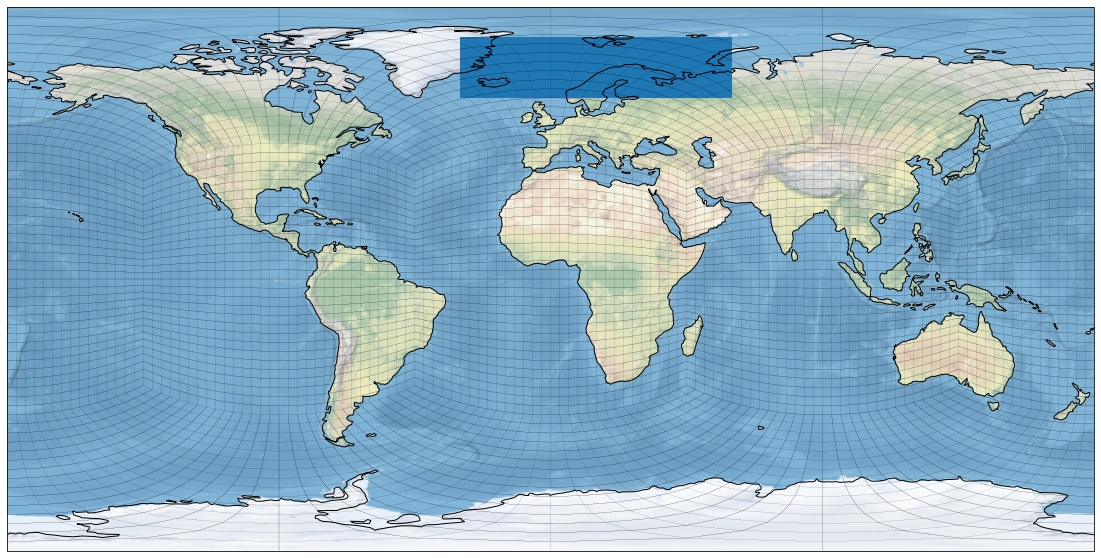

In [37]:
# Create a base image for manipulation
from matplotlib import pyplot, patches
from cartopy import crs
from xarray import open_dataset
from e3smplot.mpl.plot_exodus import plot_exodus
ds = open_dataset(f'meshes/ne{res}.g')
figure = pyplot.figure(figsize=(20, 10))
ax = figure.add_subplot(111, projection=crs.PlateCarree())
ax.stock_img()
ax.coastlines()
#ax.set_global()
pl = plot_exodus(ds, ax=ax, verbose=True, linewidth=0.1)

# Draw a polygon around our approximate refinement area
lat_bounds = ( 60, 80)
lon_bounds = (-30, 60)
vertices = [(lon_bounds[0], lat_bounds[0]), 
            (lon_bounds[1], lat_bounds[0]), 
            (lon_bounds[1], lat_bounds[1]),
            (lon_bounds[0], lat_bounds[1])]
polygon = patches.Polygon(vertices, closed=True, transform=crs.PlateCarree())
ax.add_patch(polygon)

# Save with no whitespace padding. After saving, we need to open this up in GIMP
# or something similar and fill in the elements we want on a separate layer, save
# just the new layer with the refinement patch, and load this into SQuadGen to
# generate an exodus file of the RRM.
figure.savefig(f'ne{res}_platecarre_arctic_patch.png', bbox_inches='tight', pad_inches=0.0)

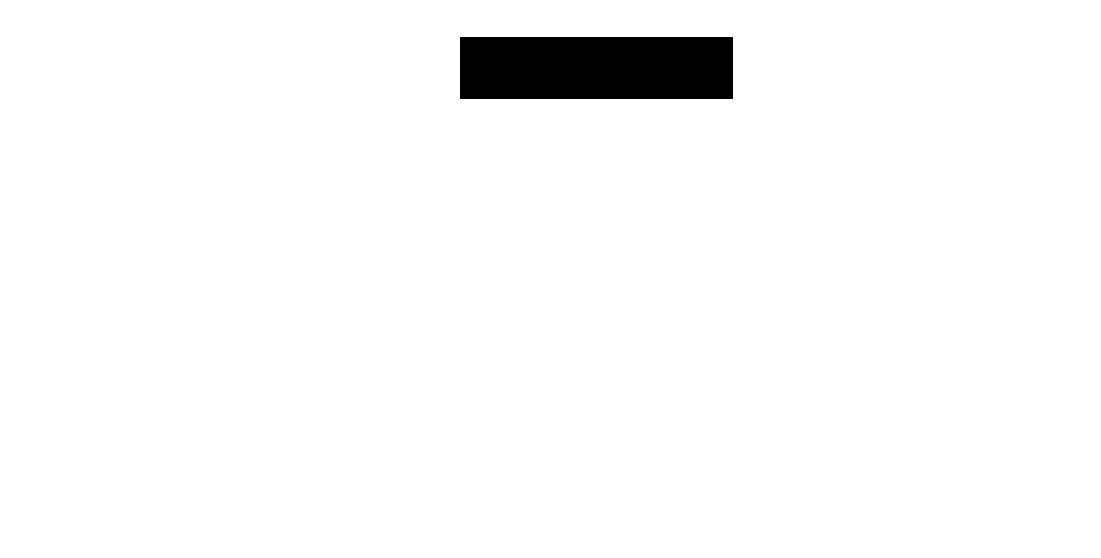

In [39]:
# Alternatively, just make a simple png with our refinement area and plug that into squadgen, 
# no interaction with image editing software required.
figure = pyplot.figure(figsize=(20, 10))
ax = figure.add_subplot(111, projection=crs.PlateCarree())
#ax.stock_img() # uncomment if you want to confirm where the patch is geographically
ax.set_global()
# NOTE: making the refinement patch black here instead of white because I had trouble getting
# a transparent background. Need to pass --invert to SQuadGen below with this image.
polygon = patches.Polygon(vertices, closed=True, color='black', transform=crs.PlateCarree())
ax.add_patch(polygon)
ax.axis('off')
figure.savefig('meshes/refinement_patch.png', bbox_inches='tight', pad_inches=0.0)

In [40]:
# Create a refined mesh with refinement area
for refine_level in (2, 3, 4):
    run(f'../squadgen/SQuadGen --resolution {res} --refine_file meshes/refinement_patch.png --refine_level {refine_level} --invert --smooth_type SPRING --output meshes/arcticstormsx{2**refine_level}v0.g'.split(' '), capture_output=True)
    
    

meshes/arcticstormsx4v0.g
Number of vertices: 7626
Longitude range: -180 to 180
Latitude range: -90 to 89
meshes/arcticstormsx8v0.g
Number of vertices: 12749
Longitude range: -180 to 180
Latitude range: -90 to 89
meshes/arcticstormsx16v0.g
Number of vertices: 30220
Longitude range: -180 to 180
Latitude range: -90 to 89


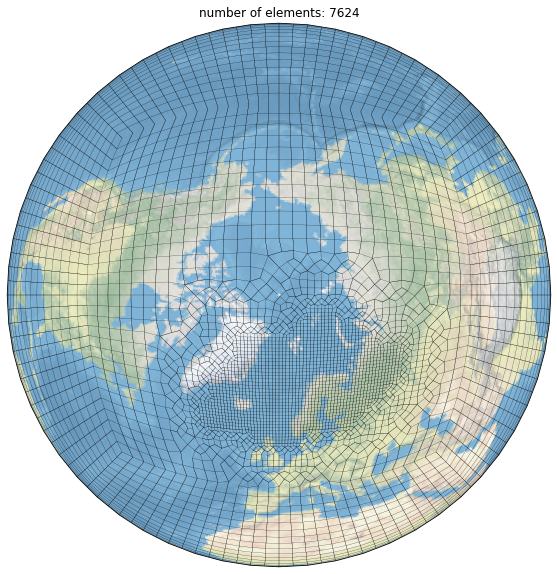

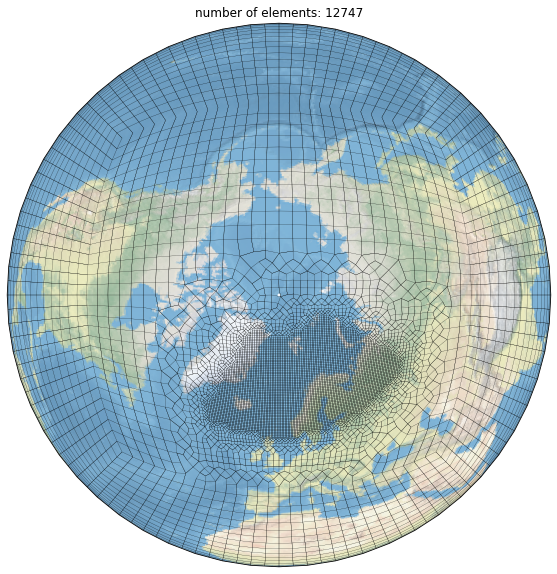

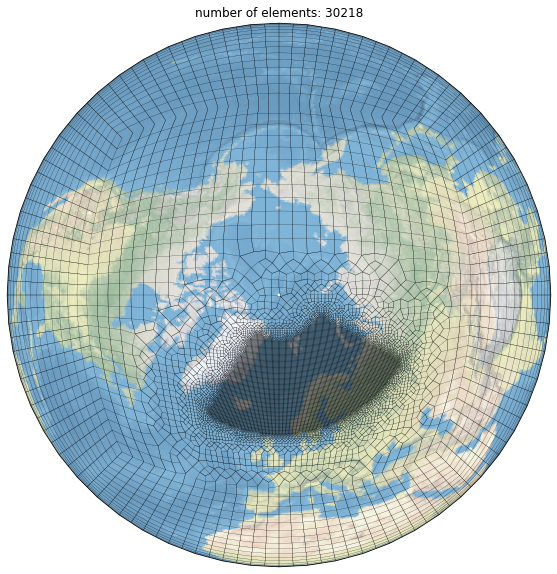

In [44]:
from os.path import splitext, basename
meshes = (
    'meshes/arcticstormsx4v0.g', 'meshes/arcticstormsx8v0.g', 'meshes/arcticstormsx16v0.g',
    #'arcticstormsx4v1.g', 'arcticstormsx8v1.g', 'arcticstormsx16v1.g',
)
os.makedirs('graphics', exist_ok=True)
for refined_mesh in meshes:
    print(refined_mesh)
    ds2 = open_dataset(refined_mesh)
    figure = pyplot.figure(figsize=(20, 10))
    ax = figure.add_subplot(111, projection=crs.Orthographic(central_latitude=90))
    ax.stock_img()
    #ax.coastlines()
    #ax.set_global()
    ax.set_title(f'number of elements: {ds2.dims["num_elem"]}')
    pl = plot_exodus(ds2, ax=ax, verbose=True, linewidth=0.2)
    figure.savefig(f'graphics/{basename(splitext(refined_mesh)[0])}.pdf', bbox_inches='tight')
    figure.savefig(f'graphics/{basename(splitext(refined_mesh)[0])}.png', bbox_inches='tight')